### Notation

Following [ExoSOFT](https://iopscience.iop.org/article/10.3847/1538-3881/aa5e4a/pdf), we let
$$\begin{align}
& v = K(\cos(\omega + \theta(t)) + e \cos \omega) \\
& \theta(t) = {\rm sign}(\pi - E(t))\arccos\left(\frac{\cos E(t) - e}{1 - e \cos E(t)}\right)  + 2 \pi {\bf 1}(E(t) > \pi)\\
& E(t) = M(t) + e \sin E(t) \quad ({\rm mod} \ 2 \pi)\\
& M(t) = \frac{2 \pi}{P} (t-T_0) \\
& K = \left(\frac{2 \pi G}{P} \right)^{\frac13} \frac{m_2 \sin(i)}{(m_1 + m_2)^{\frac23}} \frac{1}{\sqrt{1 - e^2}}
\end{align}$$
It is impossible to identify both $m_2$ and $\sin(i)$ from radial velocity alone.
Let us focus on identify 5 paremetrers,  $K$, $P$, $T_0$, $\omega$, and $e$.

------------------------------

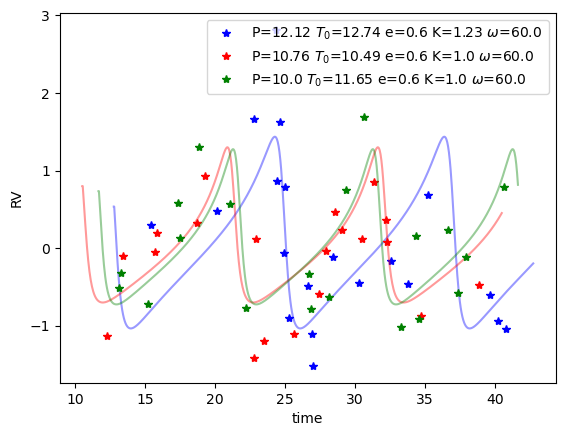

In [1]:
import numpy
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor


######################################
# generating-data functions

# Newton method to find the eccentric anomaly
def findE(M, e, n = 10, tol=1e-8):
    E = M
    f = E - M - e * numpy.sin(E)
    stop = 0
    t = 0
    while stop == 0:
        if abs(f) < tol: stop = 1
        else:
            f = E - M - e * numpy.sin(E)
            df = 1 - e * numpy.cos(E)
            E = E - f/df
            t = t + 1
        if t > n: stop = 1
    return E

# Mean anomaly
def findM(t, T0, P):
    return 2 * numpy.pi/P*(t - T0)

# Integration of the differential equation
def findTheta(T0, P, e, T, nT = 1000):
    theta = [0]
    t = [T0]
    n = 0
    deltaT = T/nT
    while n < nT:
        M = findM(t[-1], T0, P)
        E = findE(M, e)
        # modulo 2 pi
        while E >= (2 * numpy.pi): E = E - 2 * numpy.pi
        cE = numpy.cos(E)
        newTheta = numpy.arccos(max([-1, min([1, (cE - e)/(1e-8 + 1 - e * cE)])]))
        # pi-reflection
        if (E <= numpy.pi): theta.append(newTheta)
        else: theta.append(2 * numpy.pi - newTheta)
        n = n + 1
        t.append(t[-1] + deltaT)       
    return t, theta

# Radial velocity
def findVelocity(theta, K, omega1, e, gamma = 0):
    return K * (numpy.cos(theta + omega1) + e * numpy.cos(omega1)) + gamma

# Sampler
def sampling(T, v, Nsamples = 20, noise=.01):
    choice = numpy.random.choice(len(T), size=Nsamples, replace=False)
    eps = numpy.random.randn(len(T)) * numpy.mean(numpy.abs(v))
    samples = [T[i] for i in choice], [v[i] + eps[i] for i in choice]
    return samples

def simulateCurve(pars):
    P, T0, e, K, omega1 = pars
    Y = P, T0, e, K, omega1 
    alltimes, theta = findTheta(T0, P, e, T)
    v = [findVelocity(t, K, omega1, e) for t in theta]
    return alltimes, v

def generateDataset(nPlanets, pars0, rangeValues = 0.3):
    data = []
    z = []
    for r in range(nPlanets):
        # random perturbation
        print('', end='-')
        pars = pars0 * (1 + rangeValues * (numpy.random.rand(len(pars0)) > .5) * numpy.random.rand(len(pars0)))
        # compute signal and sample
        alltimes, v = simulateCurve(pars)
        times, obs = sampling(alltimes, v)    
        # save observation and all-time signal (only for plotting)
        X = times, obs
        Y = pars
        data.append([X, Y])
        z.append([alltimes, v])
    return data, z




#############################################
# Generate the synthetic data set

#reference parameters
# Orbital period
P = 10
# Observation time
T = 30 
# Time of Last Periapsis
T0 = 10
# Eccentricity
e = 0.6
# Semi-amplitude of the primary
K = 1
# Argument of Periapsis for the primary
omega = 60/180 * numpy.pi 
names = ['P', '$T_0$', 'e', 'K', '$\omega$']
pars0 = numpy.array([P, T0, e, K, omega])

# Size of the data set
nPlanets = 30 
# Relative range random parameters
rangeValue = .3
data, z = generateDataset(nPlanets, pars0, rangeValue)

colors = ['b', 'r', 'g', 'y', 'm']
for iplanet in range(3):
    X, Y = data[iplanet]
    P, T0, e, K, omega1 = Y.tolist()
    Y = P, T0, e, K, omega * 180/numpy.pi
    allTimes, Z = z[iplanet]
    times, obs = X
    plt.plot(allTimes, Z, colors[iplanet] + '-', alpha=0.4) 
    s = ''.join([names[i]+'='+str(numpy.round(Y[i], 2))+' ' for i in range(len(names))])
    plt.plot(times, obs, colors[iplanet] + '*', label=s)
plt.legend()
plt.xlabel('time')
plt.ylabel('RV')
plt.show()   

------------------------------------------------------------
 training
0-1-2-3-4-

i, mse: 0 3.6816300845147722
i, mse: 1 2.81249458996212
i, mse: 2 0.007940338484989875
i, mse: 3 0.023640922176408317
i, mse: 4 0.024410369613676132
ER [0.027944172564361627, 0.021539884382804936, 0.017314341642587338, 0.018463968259089827, 0.01832243069707907]


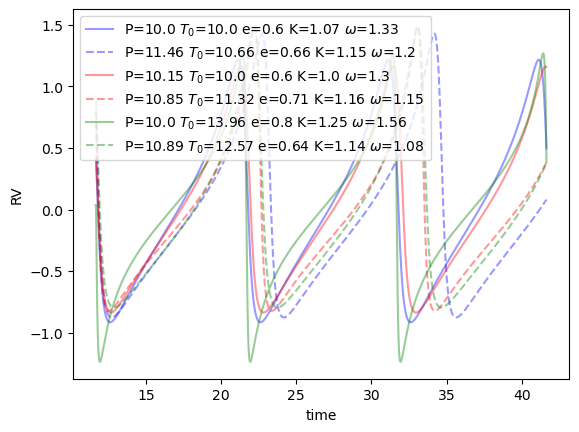

In [2]:
# Generate training and testing data
rangeValue = .5
train, z = generateDataset(nPlanets, pars0, rangeValue)
test, z = generateDataset(nPlanets, pars0, rangeValue)
print('\n training')
###############################
# Train a set of RF regressors
data = train
#prepare features
features= [[t for t in data[r][0][0]] + [v for v in data[r][0][1]] for r in range(len(data))] 
#prepare labels
ys = [[data[r][1][k] for r in range(len(data))] for k in range(len(data[0][1]))] 
#fit random forest models (one per parameter)
regressors = []
for iy in range(len(ys)):
    #fit a model for the iy-th label
    regr =  RandomForestRegressor(random_state=0)
    regr.fit(numpy.array(features), ys[iy])
    regressors.append(regr)
    print(iy, end='-')
print('\n')
###############################
# Test the models on new data
data = test
#prepare featrues
features= [[t for t in data[r][0][0]] + [v for v in data[r][0][1]] for r in range(len(data))] 
#prepare labels (to simulate the true trajectory)
ys = [[data[r][1][k] for r in range(len(data))] for k in range(len(data[0][1]))] 
#predict and compute the (normalized) ER on the parameters
ER = []
estimates = []
for iy in range(len(data[0][1])):
    regressor = regressors[iy]
    haty = regressor.predict(features)
    estimates.append(haty)
    mse = numpy.mean(numpy.power(haty - numpy.array(ys[iy]), 2))
    z = numpy.mean(abs(haty)) * numpy.mean(abs(numpy.array(ys[iy])))
    print('i, mse:', iy, mse)
    ER.append(mse/z)

print('ER', ER)

# Plot estimated trajectories and ground truth
colors = ['b', 'r', 'g', 'y', 'm']
for iplanet in range(len(features[0:3])):
    
    #true trajectory
    Y = [ys[k][iplanet] for k in range(len(ys))]
    alltimes, Z = simulateCurve(Y)    
    s = ''.join([names[i]+'='+str(numpy.round(Y[i], 2))+' ' for i in range(len(names))])
    plt.plot(allTimes, Z, colors[iplanet]+'-', alpha=0.4,  label=s) 

    #estimated trajectory    
    Y = [estimates[k][iplanet] for k in range(len(ys))]
    alltimes, Z = simulateCurve(Y)    
    s = ''.join([names[i]+'='+str(numpy.round(Y[i], 2))+' ' for i in range(len(names))])
    plt.plot(allTimes, Z, colors[iplanet]+'--', alpha=0.4,  label=s) 
plt.xlabel('time')
plt.ylabel('RV')
plt.legend()
plt.show()   
